## 소마챗 - Agentic RAG 기반 소아마취 업무 지원 챗봇

In [6]:
# 셀 1: 라이브러리 임포트 및 기본 설정
from typing import Annotated, List, TypedDict, Dict, Optional
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from dotenv import load_dotenv
import os
import json
import re
import asyncio
import pandas as pd
import xlrd

# LangChain 관련 임포트
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_pinecone import PineconeVectorStore
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import CrossEncoderReranker
from langchain_community.cross_encoders import HuggingFaceCrossEncoder
from langchain_core.runnables import RunnableConfig
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
from langgraph.prebuilt import create_react_agent
from langchain_mcp_adapters.client import MultiServerMCPClient, Connection

# 환경 변수 로드
load_dotenv()

# OpenAI 모델 설정
model = ChatOpenAI(temperature=0.1, model="gpt-4o")

In [7]:
# 셀 2: 통합 State 정의 및 메모리 설정
class ChatbotState(TypedDict):
    question: Annotated[str, "사용자 원본 질문"]
    flow_type: Annotated[str, "데이터베이스 조회 흐름"]
    patient_info: Annotated[str, "순차 처리를 위한 환자 정보"]
    decision_slack: Annotated[str, "슬랙 전송 여부 결정"]
    tools_query: Annotated[List[str], "각 DB에 전달할 쿼리 리스트"]
    neo4j_documents: Annotated[List, "Neo4j 검색 결과"]
    final_answer: Annotated[str, "최종 답변"]
    slack_response: Annotated[str, "슬랙 전송 결과"]
    messages: List[BaseMessage]

    # VectorDB Retrieval 단계에서 추가된 State
    current_query: Annotated[str, "현재 VectorDB 검색에 사용되는 쿼리"]
    query_variants: Annotated[List[str], "생성된 쿼리 변형 목록"]
    vector_documents: Annotated[str, "VectorDB 검색 결과 텍스트"]
    llm_evaluation: Annotated[Dict, "LLM 평가 결과"]
    loop_cnt: Annotated[int, "재시도 루프 카운트"]

# LangGraph 메모리 설정
memory = MemorySaver()

In [8]:
# 셀 3: MCP 클라이언트 및 도구 설정
mcp_client = MultiServerMCPClient(
    {
        "neo4j_retriever": { 
            "command": "/root/.venv/bin/python",
            "args": ["/root/mcp_neo4j_server.py"],
            "transport": "stdio",
        },
        "VectorDB_retriever": {
            "command": "/root/.venv/bin/python",
            "args": ["/root/mcp_vectordb_server.py"],
            "transport": "stdio",
        },
        "slack": {
            "command": "npx",
            "args": ["-y", "@modelcontextprotocol/server-slack"],
            "transport": "stdio", 
            "env": {
                "SLACK_BOT_TOKEN": os.getenv("SLACK_BOT_TOKEN"),
                "SLACK_TEAM_ID": os.getenv("SLACK_TEAM_ID"),
            }
        }
    } # type: ignore
)

# 비동기적으로 도구 로드 및 딕셔너리 생성
async def setup_tools():
    global tools_dict
    mcp_tools = await mcp_client.get_tools()
    tools_dict = {tool.name: tool for tool in mcp_tools}
    print("MCP 도구 설정 완료:", list(tools_dict.keys()))
    
# 이벤트 루프에서 도구 설정 실행 (Jupyter 환경)
if 'tools_dict' not in globals():
    await setup_tools()

In [9]:
# 셀 4 : 쿼리 확장용 동의어 사전 구축
xls_path = "/root/Pediatric_Terminology.xls"
df = pd.read_excel(xls_path, sheet_name=0, engine="xlrd")


In [10]:
# 셀 5: 쿼리 재작성기 및 LLM 평가기 설정

# 동의어 사전 구축
xls_path = "/root/Pediatric_Terminology.xls"

def build_term_dict_from_xls(xls_path):
    term_dict = {}
    sheets = pd.read_excel(xls_path, sheet_name=None, engine="xlrd")
    for df in sheets.values():
        df = df.rename(columns=lambda c: c.strip())
        if {"Peds Preferred Term", "Peds Synonym"} <= set(df.columns):
            for pref, syns in zip(df["Peds Preferred Term"], df["Peds Synonym"]):
                if pd.isna(pref): continue
                pref = str(pref).strip().lower()
                syn_list = [s.strip().lower() for s in re.split(r"[|;,]", str(syns)) if s and s.strip()] if isinstance(syns, str) else []
                term_dict.setdefault(pref, []).extend(syn_list + [pref])
    return {k: sorted(set(v)) for k, v in term_dict.items()}

pediatric_terms = build_term_dict_from_xls(xls_path)

# 쿼리 한글 -> 영어 번역 유틸
async def ko2en(text, model = "gpt-4o-mini"):
    llm = ChatOpenAI(model = model, temperature=0.0)
    resp = await llm.ainvoke(f"""
        You are a specialized pediatric anesthesia medical translator.

        # Task: Translate Korean medical questions to English
        - Preserve all medical terms in standard English form
        - Do not change dosages, measurements, or abbreviations
        - Maintain clinical accuracy and context
        - Use terminology from medical literature and guidelines

        # Translation Guidelines:
        - 소아 → pediatric patient / child
        - 마취 → anesthesia / anesthetic
        - 수술 → surgery / surgical procedure
        - 약물 → medication / drug
        - 부작용 → side effect / adverse effect
        - Keep drug names in original form (e.g., Ketamine, Propofol)
        - Preserve medical abbreviations (e.g., mg/kg, IV, IM)

        # Korean Question:
        {text}

        # English Translation:
        """)
    return resp.content.strip()

# 쿼리 최적화 전략
# 1차 - 원본 쿼리 사용(번역만), 2차 - 원본 기반 가벼운 최적화 (용어 표준화, 동의어 추가), 3차 - 원본 의도 보존하면서 검색 전략 변경 (확장/축소/재구성)
class AdaptiveQueryOptimizer:
    def __init__(self, model_name: str = "gpt-4o-mini", temperature: float = 0.1):
        self.llm = ChatOpenAI(model=model_name, temperature=temperature)
        self.attempt_count = 0
        self.original_question: str = ""
        self.original_question_en: str = ""
        self.previous_queries: List[str] = []
    
    async def get_search_query(self, question: str, evaluation_result: Optional[Dict] = None, state: Optional[ChatbotState] = None) -> str:
        if self.attempt_count == 0:
            self.original_question = question
            self.original_question_en = await ko2en(question) if not question.isascii() else question

        self.attempt_count += 1
        if state is not None:
            state["loop_cnt"] = self.attempt_count

        if self.attempt_count == 1:
            query = self.original_question_en
        elif self.attempt_count == 2:
            query = await self._light_optimization(evaluation_result)
        else:
            query = await self._strategic_reformulation(evaluation_result)

        self.previous_queries.append(query)
        return query
    
    # 2차 방식 구현
    async def _light_optimization(self, eval_result):
        prompt = f"""
        You are a pediatric anesthesia medical search expert.
        Optimize queries to improve vector DB search performance while completely preserving the original question's intent.
        
        Pediatric anesthesia medical synonym dictionary: {json.dumps(pediatric_terms, ensure_ascii=False)}
        
        Optimization Guidelines:
        1. Never change the core intent and context of the original question
        2. Standardize medical terminology (e.g., 소아 → pediatric)
        3. Naturally integrate synonyms (no OR operators)
        4. Replace with clearer and more specific medical terms
        5. Keep drug names, numbers, and abbreviations as they are
        
        Good Examples:
        - "신생아 심장수술" → "neonatal cardiac surgery procedures"
        - "소아 진통제" → "pediatric analgesic medications"
        
        Bad Examples:
        - "neonatal OR newborn cardiac surgery" (using OR operators)
        - "child infant baby surgery" (listing synonyms)
        
        Original Question: {self.original_question}
        English Translation: {self.original_question_en}
        Previous Search Issues: {eval_result.get('feedback', 'Low relevance') if eval_result else 'Low relevance'}
        
        Optimized Search Query:
        """
        return (await self.llm.ainvoke(prompt)).content.strip()
    
    # 3차 방식 구현
    async def _strategic_reformulation(self, eval_result):
        prompt = f"""
        You are a pediatric anesthesia medical search expert.
        Change only the search expression while completely preserving the original question's intent.
        
        Strict Safety Constraints:
        1. Never add medical information not present in the original
        2. Do not create new symptoms, procedures, drugs, or complications
        3. Do not make inferences or assumptions
        4. Use only information present in the original
        
        Safe Strategy Changes:
        - Change word order (dosage pediatric → pediatric dosage)
        - Use synonyms (side effects → adverse effects)
        - Change expression style (sentence → keywords)
        - Remove unnecessary words
        
        Absolutely Prohibited (false information generation):
        - Original: "프로포폴 부작용" → "프로포폴 부작용 심혈관계" (adding cardiovascular prohibited)
        - Original: "진통제 용량" → "진통제 용량 수술중" (adding intraoperative prohibited)
        - Original: "신생아 마취" → "신생아 마취 기관삽관" (adding intubation prohibited)
        
        Safe Examples:
        - Original: "프로포폴 부작용" → "propofol adverse reactions"
        - Original: "신생아 진통제 용량" → "analgesic dosing neonates"
        - Original: "소아 마취 관리" → "pediatric anesthesia management"
        
        Original Question: {self.original_question}
        English Translation: {self.original_question_en}
        Previous Search Issues: {eval_result.get('feedback', 'Previous attempts failed') if eval_result else 'Previous attempts failed'}
        
        Optimized Search Query:
        """
        return (await self.llm.ainvoke(prompt)).content.strip()
    
    def reset(self):
        """새 질문 시작 시 리셋"""
        self.attempt_count = 0
        self.original_question = None
        self.original_question_en = None
        self.previous_queries = []

# LLM 기반 쿼리 및 Retrieval 평가기
class LLMEvaluator:
    def __init__(self, model_name="gpt-4o-mini", temperature=0.0):
        self.judge = ChatOpenAI(model = model_name , temperature=temperature, max_completion_tokens=1024)

    # 검색 결과 평가
    async def evaluate_search_results(self, query, docs):
        if not docs: return None
        previews = [d[:200].replace("\n", " ") + "…" for d in docs[:3]]
        prompt = f"""
            You are an independent evaluator for a PubMed-based RAG system.
            Task ◂ Evaluate how well the retrieved abstracts answer the user's question.
            Evaluation metrics (0-1):
            1. relevance – Degree of topical overlap between question and abstracts
            2. faithfulness – Factual consistency: Does the evidence really support the answer?
            3. completeness – Does the evidence cover all key aspects of the question?
            **Return only one JSON**: {{\"relevance\": 0.0, \"faithfulness\": 0.0, \"completeness\": 0.0, \"overall\": 0.0, \"feedback\": \"\"}}
            overall = 0.3 * relevance + 0.5 * faithfulness + 0.2 * completeness
            User Question: \"{query}\"
            Evidence Preview:
            - {previews[0]}
            - {previews[1] if len(previews)>1 else ''}
            - {previews[2] if len(previews)>2 else ''}
            """
        try:
            raw = str((await self.judge.ainvoke(prompt)).content).strip()
            json_match = re.search(r"\{.*\}", raw, re.S)
            if json_match:
                data = json.loads(json_match.group())
                # 필수 키 누락 체크
                required_keys = ("relevance", "faithfulness", "completeness")
                missing_keys = [k for k in required_keys if k not in data]
                if missing_keys:
                    raise ValueError(f"Missing required keys: {missing_keys}")
            else:
                raise ValueError("JSON parsing failed")
            # 소아마취 도메인: faithfulness 우선 (의료 안전성)
            if "overall" not in data:
                data["overall"] = round(0.3*data["relevance"] + 0.5*data["faithfulness"] + 0.2*data["completeness"], 3)
            
            # 의료 도메인 특화 임계값 (연구 기반)
            data["recommended_threshold"] = 0.7  # 높은 신뢰성 요구
            return data
            
        except Exception as e: 
            # 평가 실패 시 None 반환하여 상위에서 처리
            return None

    # 평가 실패 시 재시도
    async def should_retry_search(self, ev, turn, max_turn):
        return ev.get("overall", 0) < ev.get("recommended_threshold", 0.7) and turn < max_turn

    # 실제 검색 품질 기반으로 최고의 쿼리를 선택
    async def select_best_query(self, query_variants, vectordb_tool, original_question=""):
        if not query_variants:
            return original_question, {}
        
        if not vectordb_tool:
            print("CRITICAL ERROR: VectorDB_retriever tool not found.")
            return original_question, {"feedback": "VectorDB_retriever tool not found"}

        if len(query_variants) == 1:
            response_tuple = await vectordb_tool.ainvoke({"query": query_variants[0]})
            docs_text_str = response_tuple[0] if isinstance(response_tuple, tuple) else str(response_tuple)
            docs_text = [doc.strip() for doc in docs_text_str.split("\n\n") if doc.strip()]
            evaluation = await self.evaluate_search_results(query_variants[0], docs_text)
            return query_variants[0], evaluation or {}
        print(f"{len(query_variants)}개 쿼리 변형에 대해 검색 품질 평가 시작")
        
        best_query = query_variants[0]
        best_score = 0
        best_evaluation = {}
        
        for i, query in enumerate(query_variants):
            try:
                print(f"쿼리 {i+1}/{len(query_variants)}: {query}")
                
                response_tuple = await vectordb_tool.ainvoke({"query": query})
                docs_text_str = response_tuple[0] if isinstance(response_tuple, tuple) else str(response_tuple)
                docs_text = [doc.strip() for doc in docs_text_str.split("\n\n") if doc.strip()]

                evaluation = await self.evaluate_search_results(query, docs_text)
                if evaluation is None:
                    continue
                    
                overall_score = evaluation.get("overall", 0)
                print(f"평가 점수: {overall_score:.3f}")
                print(f"세부점수 - 관련성:{evaluation.get('relevance', 0):.2f} "
                      f"일치도:{evaluation.get('faithfulness', 0):.2f} "
                      f"완성도:{evaluation.get('completeness', 0):.2f}")
                
                if overall_score > best_score:
                    best_score = overall_score
                    best_query = query
                    best_evaluation = evaluation
                    print(f"현재 최고 쿼리 업데이트!")
            except Exception as e:
                print(f"쿼리 평가 중 오류: {e}")
        
        print(f"최종 선택된 쿼리: {best_query}")
        print(f"최고 점수: {best_score:.3f}")
        print(f"선택 근거: {best_evaluation.get('feedback', '평가 완료')}")
        
        return best_query, best_evaluation

    # 상위 K개의 쿼리와 평가 결과를 반환
    async def select_multiple_queries(self, query_variants, vectordb_tool, original_question="", top_k=2):
        if not vectordb_tool:
            print("CRITICAL ERROR: VectorDB_retriever tool not found.")
            return [(original_question, {"feedback": "VectorDB_retriever tool not found"})]
        if not query_variants or len(query_variants) <= top_k:
            results = []
            for query in query_variants or [original_question]:
                try:
                    response_tuple = await vectordb_tool.ainvoke({"query": query})
                    docs_text_str = response_tuple[0] if isinstance(response_tuple, tuple) else str(response_tuple)
                    docs_text = [doc.strip() for doc in docs_text_str.split("\n\n") if doc.strip()]
                    evaluation = await self.evaluate_search_results(query, docs_text)
                    results.append((query, evaluation or {}))
                except Exception as e:
                    print(f"쿼리 '{query}' 평가 실패: {e}")
                    # 평가 실패한 쿼리는 제외
            return results
        
        print(f"상위 {top_k}개 쿼리 선택을 위한 전체 평가 시작")
        
        scored_queries = []
        for query in query_variants:
            try:
                response_tuple = await vectordb_tool.ainvoke({"query": query})
                docs_text_str = response_tuple[0] if isinstance(response_tuple, tuple) else str(response_tuple)
                docs_text = [doc.strip() for doc in docs_text_str.split("\n\n") if doc.strip()]
                
                evaluation = await self.evaluate_search_results(query, docs_text)
                overall_score = evaluation.get("overall", 0) if evaluation else 0
                scored_queries.append((query, evaluation or {}, overall_score))
            except Exception as e:
                print(f"쿼리 '{query}' 평가 실패: {e}")
                # 평가 실패한 쿼리는 제외 (0.3 같은 임의 점수 부여하지 않음)
        
        scored_queries.sort(key=lambda x: x[2], reverse=True)
        selected = [(query, evaluation) for query, evaluation, score in scored_queries[:top_k]]
        
        print(f"상위 {top_k}개 쿼리 선택 완료:")
        for i, (query, evaluation) in enumerate(selected):
            print(f"  {i+1}. {evaluation.get('overall', 0):.3f} | {query}")
        
        return selected

# 전역 인스턴스 생성
adaptive_optimizer = AdaptiveQueryOptimizer()
llm_evaluator = LLMEvaluator()

# 최대 재작성 시도 횟수
max_retry_attempts = 4 

In [11]:
# 셀 6 : 유틸리티 함수
# 문서 중복 제거 유틸리티
def remove_duplicates_and_rank(docs):
    """검색된 문서에서 중복 제거"""
    seen = set()
    unique_docs = []
    
    for doc in docs:
        content_hash = hash(doc.page_content[:200])
        if content_hash not in seen:
            seen.add(content_hash)
            unique_docs.append(doc)
    
    return unique_docs


In [12]:
# 셀 7 : 호환성을 위한 래퍼 함수들
# 실제 로직은 AdaptiveQueryOptimizer와 LLMEvaluator 클래스에서 처리
async def select_best_query_with_llm_evaluator(query_variants, original_question=""):
    vectordb_tool = tools_dict.get("VectorDB_retriever")
    return await llm_evaluator.select_best_query(query_variants, vectordb_tool, original_question)

async def select_multiple_best_queries_with_evaluation(query_variants, original_question, top_k=2):
    vectordb_tool = tools_dict.get("VectorDB_retriever")
    return await llm_evaluator.select_multiple_queries(query_variants, vectordb_tool, original_question, top_k)

In [13]:
# 셀 8: 모든 프롬프트 정의
# [최적화] 라우터 에이전트용 프롬프트
ROUTER_PROMPT = """
You are an expert router that creates an efficient database query plan for a user's medical question.
Your task is to determine a `flow_type` from ['sequential', 'parallel', 'neo4j_only', 'vector_db_only'] and generate the necessary queries.

# Core Rule:
The most important rule is to distinguish if the query is about a **specific, identifiable patient (by name or ID)** which requires `neo4j_db`, or about a **general patient type** (e.g., 'a 3-year-old patient') which requires `vector_db_only`. If there is no specific identifier, default to `vector_db_only` for medical knowledge questions.

# Examples:

User Question: "환자 김민준의 나이와 성별을 알려줘."
{
  "flow_type": "neo4j_only",
  "neo4j_query": "환자 김민준의 나이와 성별 조회"
}

User Question: "케타민의 일반적인 부작용은 무엇인가요?"
{
  "flow_type": "vector_db_only",
  "vector_db_query": "케타민의 일반적인 부작용"
}

User Question: "3세 Kasabach-Merritt Syndrome 환자의 치료법에 대해서 조사해서 박혜원에게 slack으로 보내줘."
{
  "flow_type": "vector_db_only",
  "vector_db_query": "3세 Kasabach-Merritt Syndrome 환자의 치료법"
}

User Question: "김민준 환자의 진단명을 알려주고, 그 진단명의 일반적인 치료법도 설명해줘."
{
  "flow_type": "sequential",
  "neo4j_query": "김민준 환자의 진단명 조회"
  // The vector_db_query is omitted here because it will be generated in a later step using the result from the neo4j_query.
}

User Question: "환자 박서준의 최근 수술 이력을 알려주고, 케타민의 소아 사용 사례도 알려줘."
{
  "flow_type": "parallel",
  "neo4j_query": "환자 박서준의 최근 수술 이력 조회",
  "vector_db_query": "케타민의 소아 사용 사례"
}
"""


# 순차 흐름에서 VectorDB 쿼리 생성을 위한 프롬프트 
VECTOR_QUERY_GEN_PROMPT = """
You are an AI that generates the single most effective search term to retrieve relevant medical information from a Vector DB based on the user’s question and patient data.

# User’s Original Question:
{question}

# Retrieved Patient Information (Neo4j):
{patient_info}

# Instructions:
Using the above information, create one concise and clear search keyword that will allow the Vector DB to find the specific medical fact the user is truly interested in (e.g., clinical knowledge, drug side effects, surgical precautions, disease prognosis, etc.). Extract the core medical terms from the patient data (such as surgery name, drug name, diagnosis) and use them to form the search term.

Search term:
"""


# 최종 답변 생성을 위한 프롬프트
LLM_SYSTEM_PROMPTY = """
# INSTRUCTION
You are an expert AI specialized in medical data.
Based on the provided database search results, generate a medically accurate and easy-to-understand answer to the user’s question.
- If only one set of results is available, base your answer solely on that.
- Even if the results are sparse or ambiguous, strive to provide a meaningful explanation.
- Deliver your answer directly without unnecessary preamble.

# Search Results:
## Neo4j Patient Information:
{Neo4j}

## VectorDB Medical Information:
{VectorDB}

# User Question:
{question}

# Answer:
"""


# 슬랙 사용 여부 결정을 위한 프롬프트
LLM_DECISION_SLACK = """
You are a decision-making assistant for Slack dispatch.
If the user asks to send a message or question to a specific person via Slack (e.g., '~에게 보내줘', '~에게 전송해줘'),
respond with "Yes".
Otherwise, respond with "No".

Only respond with "Yes" or "No". Do not include any explanation or formatting.
"""

In [14]:
# 셀 9: 라우터 함수 스키마 및 Graph 흐름 제어

# 라우터 에이전트용 함수 스키마
tool_router_schema = {
    "name": "route_question",
    "description": "사용자 질문의 의도를 파악하여 가장 적절한 데이터 조회 경로와 각 DB에 필요한 쿼리를 결정합니다.",
    "parameters": {
        "type": "object",
        "properties": {
            "flow_type": {
                "type": "string",
                "enum": ["sequential", "parallel", "neo4j_only", "vector_db_only"],
                "description": "질문에 가장 적합한 데이터 처리 흐름"
            },
            "neo4j_query": {
                "type": "string",
                "description": """Neo4j 환자 DB에서 구조화된 환자별 임상 정보를 조회하기 위한 자연어 쿼리입니다.
                사용자 질문에 '환자', '환자기록', '수술이력', '진단명' 등 명확한 환자 데이터 관련 용어가 포함될 때 사용하세요.
                flow_type이 'neo4j_only', 'parallel', 'sequential'일 경우에만 생성됩니다."""
            },
            "vector_db_query": {
                "type": "string",
                "description": """Vector DB에서 일반적인 의학/임상 지식을 검색하기 위한 자연어 쿼리입니다.
                '전신마취', '케타민', '수술 부작용' 등 특정 환자와 무관한 의학 개념, 절차, 가이드라인에 대한 질문일 때 사용하세요.
                flow_type이 'vector_db_only' 또는 'parallel'일 경우에만 생성됩니다. 'sequential' 흐름에서는 이 필드를 사용하지 않습니다."""
            }
        },
        "required": ["flow_type"]
    }
}


# 라우터의 결정에 따라 다음 노드로 분기하기 위해 flow_type을 반환
def route_after_router(state: ChatbotState) -> str:
    flow_type = state['flow_type']
    print(f"--- Routing Decision: {flow_type} ---")
    # 이 함수는 flow_type 문자열 자체를 반환하고,
    # add_conditional_edges의 딕셔너리가 이 값을 키로 사용해 실제 목적지 노드를 찾습니다.
    return flow_type


# [수정] Neo4j 노드 이후의 조건부 분기 함수
def route_after_neo4j(state: ChatbotState) -> str:
    """Neo4j 검색 후, 흐름에 따라 다음 행동을 결정하는 키워드를 반환"""
    flow_type = state['flow_type']
    if flow_type == 'sequential':
        return "generate_vector_query"  # sequential -> VectorDB 쿼리 생성
    elif flow_type == 'parallel':
        return "start_vector_db_flow"   # parallel -> VectorDB 흐름 시작
    else: # neo4j_only
        return "go_to_merge"            # neo4j_only -> 바로 최종 답변으로



# [수정] LLM 평가 이후의 조건부 분기 함수
def route_after_evaluation(state: ChatbotState) -> str:
    """LLM 평가 결과에 따라 다음 행동을 결정하는 키워드를 반환"""
    evaluation = state.get("llm_evaluation", {})
    loop_cnt = state.get("loop_cnt", 0)
    should_retry = evaluation.get("overall", 0) < evaluation.get("recommended_threshold", 0.7) and loop_cnt < max_retry_attempts
    
    if should_retry:
        print(f"--- Routing: Quality insufficient (Score: {evaluation.get('overall', 0):.3f}). Retrying... ---")
        return "retry_rewrite"
    else:
        print(f"--- Routing: Quality sufficient or max retries reached. Generating answer... ---")
        return "generate_answer"

In [15]:
# 셀 10: 통합 Graph 노드 함수 정의

# [기존] 라우터, 슬랙 결정, Neo4j DB 검색 노드
async def router_agent(state: ChatbotState) -> ChatbotState:
    print("\n--- [Node] Router Agent ---")
    question = state["question"]
    model_with_tools = model.with_structured_output(tool_router_schema) # tool_router_schema는 아래 셀에서 정의
    response = await model_with_tools.ainvoke([HumanMessage(content=ROUTER_PROMPT), HumanMessage(content=question)])
    print(f"Flow Type: {response.get('flow_type')}")
    return ChatbotState(
        flow_type=response.get("flow_type"),
        tools_query=[response.get("neo4j_query", ""), response.get("vector_db_query", "")]
    )

# [추가] 슬랙 사용 여부 판단 노드
def determine_slack_usage(query: str) -> str:
    """간단한 규칙 기반으로 슬랙 사용 여부를 1차 판단하는 헬퍼 함수"""
    SEND_COMMANDS = ["보내줘", "전송해줘", "전달해줘"]
    return 'Yes' if any(cmd in query for cmd in SEND_COMMANDS) or "에게" in query else 'No'

async def decision_slack(state: ChatbotState):
    """사용자 질문을 바탕으로 슬랙 메시지 전송이 필요한지 최종 결정하는 노드"""
    print("\n--- [Node] Decision Slack ---")
    user_query = state["question"]
    
    # 규칙 기반으로 1차 판단
    use_slack = determine_slack_usage(user_query)
    
    # 최종 결정을 response 변수에 저장 (기본값은 규칙 기반 판단 결과)
    response = use_slack
    
    print(f"Slack Decision: {response}")
    return ChatbotState(decision_slack=response)

async def neo4j_db(state: ChatbotState) -> ChatbotState:
    print("\n--- [Node] Neo4j DB Retriever ---")
    query = state['tools_query'][0]
    if not query: return ChatbotState(neo4j_documents=["Neo4j 쿼리가 제공되지 않았습니다."])
    try:
        neo4j_tool = tools_dict.get("neo4j_retriever")
        raw_result, _ = await neo4j_tool.ainvoke({"query": query})
        result = raw_result
    except Exception as e:
        result = [f"Neo4j 도구 실행 중 오류: {e}"]
    print(f"Neo4j Result: {result}")
    if state['flow_type'] == 'sequential':
        return ChatbotState(neo4j_documents=result, patient_info=str(result))
    return ChatbotState(neo4j_documents=result)

async def generate_vector_query_node(state: ChatbotState) -> ChatbotState:
    print("\n--- [Node] Generate VectorDB Query (Sequential) ---")
    prompt = VECTOR_QUERY_GEN_PROMPT.format(question=state['question'], patient_info=state['patient_info'])
    response = await model.ainvoke(prompt)
    generated_query = response.content
    print(f"Generated VectorDB Query: {generated_query}")
    state['tools_query'][1] = generated_query
    return ChatbotState(tools_query=state['tools_query'])

# --- [신규] VectorDB 검색 및 평가 루프 관련 노드 ---
async def adaptive_query_rewriter_node(state: ChatbotState) -> ChatbotState:
    loop_cnt = state.get("loop_cnt", 0)
    prev_eval = state.get("llm_evaluation", {})
    question = state["question"]

    query = await adaptive_optimizer.get_search_query(
        question,
        evaluation_result=prev_eval,
        state=state
    )
    state["current_query"] = query

    vectordb_tool = tools_dict.get("VectorDB_retriever")
    response = await vectordb_tool.ainvoke({"query": query})
    docs_str = response[0] if isinstance(response, (list, tuple)) else str(response)
    docs = [d.strip() for d in docs_str.split("\n\n") if d.strip()]

    evaluation = await llm_evaluator.evaluate_search_results(query, docs) or {}
    state["llm_evaluation"] = evaluation

    state["loop_cnt"] = loop_cnt + 1

    return state

async def vector_retrieval_node(state: ChatbotState) -> ChatbotState:
    """VectorDB에서 문서를 검색하는 노드 (MCP Tool 호출 방식)"""
    print(f"\n--- [Node] VectorDB Retriever ---")
    current_query = state.get("current_query")
    print(f"Retrieve with query: {current_query}")

    try:
        # 도구 딕셔너리에서 VectorDB 리트리버 도구를 가져옴
        vectordb_tool = tools_dict.get("VectorDB_retriever")
        if not vectordb_tool:
            raise ValueError("VectorDB_retriever 도구를 찾을 수 없습니다.")

        # MCP 도구를 비동기적으로 호출
        # mcp 도구의 결과는 (content, artifact) 튜플 형태일 수 있으므로 첫 번째 요소(content)를 사용
        response_tuple = await vectordb_tool.ainvoke({"query": current_query})
        result_text = response_tuple[0] if isinstance(response_tuple, tuple) else str(response_tuple)

    except Exception as e:
        print(f"!!! VectorDB 검색 중 오류 발생: {e}")
        result_text = f"VectorDB 검색에 실패했습니다: {e}"

    return ChatbotState(vector_documents=result_text)

async def llm_evaluation_node(state: ChatbotState) -> ChatbotState:
    """검색 결과 품질 평가 노드"""
    # 첫 시도(loop_cnt==1)에서는 rewriter_node에서 이미 평가했으므로 건너뛸 수 있으나,
    # 재시도 루프에서는 새로 검색된 결과에 대한 평가가 필요하므로 실행합니다.
    if state.get('loop_cnt', 0) > 1:
        print(f"\n--- [Node] LLM Re-Evaluation ---")
        docs_list = [d.strip() for d in state.get("vector_documents", "").split("\n\n") if d.strip()]
        evaluation = await llm_evaluator.evaluate_search_results(state.get("current_query"), docs_list)
        print(f"Re-Evaluation Score: {evaluation.get('overall', 0):.3f}")
        return ChatbotState(llm_evaluation=evaluation)
    else:
        # 첫 번째 루프에서는 gpt_query_rewriter_node에서 계산된 평가를 그대로 사용
        print(f"\n--- [Node] LLM Evaluation (Using Initial Score) ---")
        return ChatbotState(llm_evaluation=state.get('llm_evaluation'))



async def test_find_user_id(name_to_find: str):
    """
    특정 이름으로 Slack 사용자 ID를 찾는지 테스트하는 함수
    """
    print(f"--- '{name_to_find}'님의 사용자 ID 조회를 시작합니다 ---")
    
    try:
        # 1. 'slack_get_users' 도구를 tools_dict에서 가져옵니다.
        users_tool = tools_dict.get("slack_get_users")
        if not users_tool:
            raise ValueError("slack_get_users 도구를 tools_dict에서 찾을 수 없습니다.")

        # 2. 도구를 호출하여 전체 사용자 목록을 가져옵니다.
        raw_users_response = await users_tool.ainvoke({})
        users_response_str = str(raw_users_response[0]) if isinstance(raw_users_response, tuple) else str(raw_users_response)
        
        # 3. JSON 응답을 파싱하고 'members' 리스트를 추출합니다.
        response_data = json.loads(users_response_str)
        if not response_data.get("ok"):
            raise ValueError(f"슬랙 사용자 목록을 가져오는 데 실패했습니다: {response_data.get('error', 'Unknown error')}")
        
        users_list = response_data.get("members", [])
        
        # 4. 리스트를 순회하며 일치하는 사용자를 찾습니다.
        found_user_id = None
        for user in users_list:
            if name_to_find in user.get('real_name', '') or name_to_find in user.get('name', ''):
                found_user_id = user.get('id')
                break # 찾으면 즉시 중단

        # 5. 결과를 출력합니다.
        if found_user_id:
            print(f"\n[결과] 성공: '{name_to_find}'님의 사용자 ID는 '{found_user_id}' 입니다.")
        else:
            print(f"\n[결과] 실패: '{name_to_find}'님을 슬랙 사용자 목록에서 찾을 수 없습니다.")
            print("이름이 정확한지 또는 해당 사용자가 워크스페이스에 존재하는지 확인해주세요.")

    except Exception as e:
        print(f"\n[오류] 테스트 중 오류가 발생했습니다: {e}")

# --- 테스트 실행 ---
await test_find_user_id("박혜원")


--- '박혜원'님의 사용자 ID 조회를 시작합니다 ---

[결과] 성공: '박혜원'님의 사용자 ID는 'U0934T7LX6K' 입니다.


In [16]:
# 셀 7의 merge_and_respond_node 함수 (최종 수정: 사용자 목록 처리 오류 해결)
import re
import json
from langchain_core.messages import AIMessage, HumanMessage

async def merge_and_respond_node(state: ChatbotState) -> ChatbotState:
    """
    최종 답변을 생성하고, 동적으로 사용자 ID를 찾아 @멘션하여 슬랙으로 전송합니다.
    """
    print("\n--- [Node] Merge and Respond ---")
    question = state.get("question", "")
    final_answer = ""
    slack_response_text = ""

    try:
        # 1. 최종 답변 생성
        prompt = LLM_SYSTEM_PROMPTY.format(
            Neo4j=state.get("neo4j_documents", ""),
            VectorDB=state.get("vector_documents", ""),
            question=question
        )
        response = await model.ainvoke(prompt)
        final_answer = response.content
        print(f"Final Answer Generated: {final_answer[:100]}...")

        # 2. 슬랙 전송 결정 여부에 따라 @멘션 로직 실행
        if state.get('decision_slack', 'no').lower() == 'yes':
            print("--- Sending to Slack with @mention (Dynamic User Lookup) ---")

            # 2-1. .env 파일에서 공용 채널 ID 가져오기
            target_channel_id = os.getenv("SLACK_CHANNEL")
            if not target_channel_id:
                raise ValueError("SLACK_CHANNEL 환경 변수가 .env 파일에 설정되지 않았습니다.")

            # 2-2. 정교한 정규 표현식으로 수신인 이름 추출
            recipient_name = None
            match = re.search(r"(\S+)\s*(?:에게|님에게|한테)", question)
            if match:
                recipient_name = match.group(1).strip()
            
            if not recipient_name:
                raise ValueError("질문에서 수신인 이름을 찾을 수 없습니다. (예: 'OOO에게')")
            print(f"Recipient Name Extracted: {recipient_name}")

            # 2-3. [수정] 사용자 ID를 안전하게 조회하고 올바르게 파싱
            users_tool = tools_dict.get("slack_get_users")
            if not users_tool:
                raise ValueError("slack_get_users 도구를 찾을 수 없습니다.")
            
            raw_users_response = await users_tool.ainvoke({})
            users_response_str = str(raw_users_response[0]) if isinstance(raw_users_response, tuple) else str(raw_users_response)
            
            # JSON 문자열을 딕셔너리로 파싱
            response_data = json.loads(users_response_str)
            
            # 응답이 성공적이고 'members' 키가 있는지 확인 후, 실제 사용자 리스트를 가져옴
            if response_data.get("ok"):
                users_list = response_data.get("members", [])
            else:
                raise ValueError(f"슬랙 사용자 목록을 가져오는 데 실패했습니다: {response_data.get('error', 'Unknown error')}")

            user_id_to_mention = None
            for user in users_list:
                # user가 이제 딕셔너리이므로 .get() 메소드 정상 작동
                if recipient_name in user.get('real_name', '') or recipient_name in user.get('name', ''):
                    user_id_to_mention = user.get('id')
                    break
            
            if not user_id_to_mention:
                raise ValueError(f"'{recipient_name}'님을 슬랙 사용자로 찾을 수 없습니다.")
            print(f"User ID Found: {user_id_to_mention}")

            # 2-4. @멘션을 포함한 최종 메시지 텍스트 생성
            text_to_send = f"<@{user_id_to_mention}> 님, 요청하신 정보입니다.\n\n{final_answer}"

            # 2-5. slack_post_message 도구를 안전하게 호출
            slack_tool = tools_dict.get("slack_post_message")
            if not slack_tool:
                raise ValueError("slack_post_message 도구를 찾을 수 없습니다.")
            
            tool_input = {"channel_id": target_channel_id, "text": text_to_send}
            
            raw_slack_response = await slack_tool.ainvoke(tool_input)
            slack_response_text = str(raw_slack_response[0]) if isinstance(raw_slack_response, tuple) else str(raw_slack_response)
            
            print(f"Slack Direct Call Response: {slack_response_text}")

    except Exception as e:
        error_message = f"슬랙 전송 또는 답변 생성 중 오류 발생: {e}"
        print(f"!!! {error_message}")
        slack_response_text = error_message
        if not final_answer:
            final_answer = "답변을 생성하는 중 오류가 발생했습니다."

    # 3. 최종 상태 반환
    return ChatbotState(
        final_answer=final_answer,
        slack_response=slack_response_text,
        messages=[HumanMessage(content=question), AIMessage(content=final_answer)]
    )

Adaptive 최종 그래프 컴파일 완료!


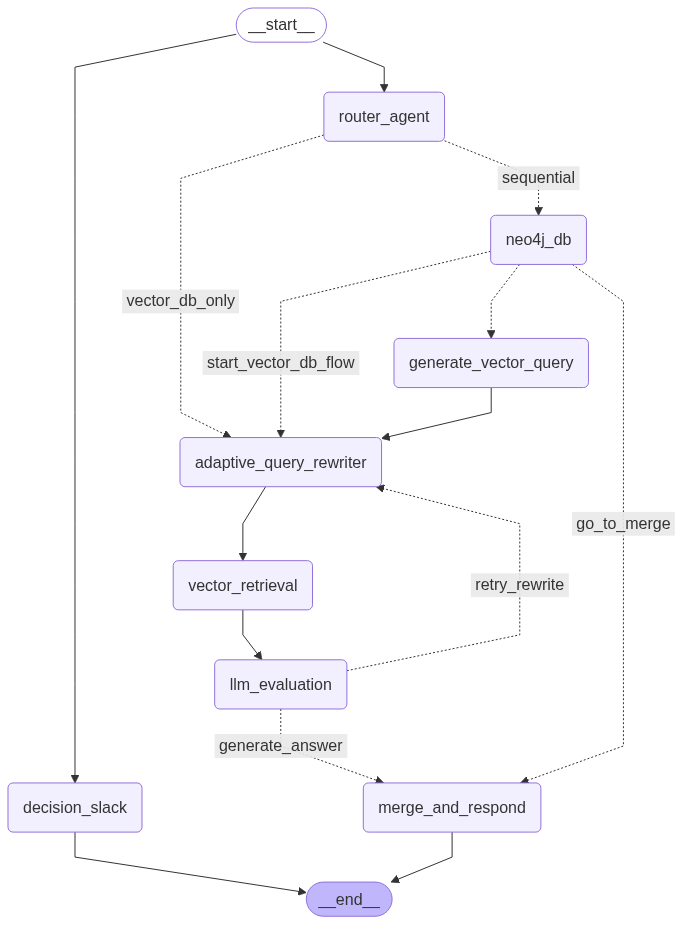

In [19]:
# ==============================================================================
# 셀 9: 최종 Graph 빌드 및 컴파일 (Adaptive 버전)
# ==============================================================================
workflow = StateGraph(ChatbotState)

# 1. 모든 노드 정의
workflow.add_node("router_agent", router_agent)
workflow.add_node("decision_slack", decision_slack)
workflow.add_node("neo4j_db", neo4j_db)
workflow.add_node("generate_vector_query", generate_vector_query_node)
workflow.add_node("adaptive_query_rewriter", adaptive_query_rewriter_node)
workflow.add_node("vector_retrieval", vector_retrieval_node)
workflow.add_node("llm_evaluation", llm_evaluation_node)
workflow.add_node("merge_and_respond", merge_and_respond_node)

# 2. 시작점 엣지 연결
workflow.add_edge(START, "router_agent")
workflow.add_edge(START, "decision_slack")

# 3. 라우터 이후 조건부 분기
workflow.add_conditional_edges(
    "router_agent",
    route_after_router,
    {
        "neo4j_only": "neo4j_db",
        "vector_db_only": "adaptive_query_rewriter",
        "parallel": "neo4j_db",
        "sequential": "neo4j_db",
    }
)

# 4. Neo4j 이후 조건부 분기
workflow.add_conditional_edges(
    "neo4j_db",
    route_after_neo4j,
    {
        "go_to_merge": "merge_and_respond",
        "generate_vector_query": "generate_vector_query",
        "start_vector_db_flow": "adaptive_query_rewriter",
    }
)

# 5. 순차 흐름: generate_vector_query → adaptive_query_rewriter
workflow.add_edge("generate_vector_query", "adaptive_query_rewriter")

# 6. Adaptive 쿼리 재작성 → VectorDB 검색 → 평가
workflow.add_edge("adaptive_query_rewriter", "vector_retrieval")
workflow.add_edge("vector_retrieval", "llm_evaluation")

# 7. 평가 이후 재시도 루프
workflow.add_conditional_edges(
    "llm_evaluation",
    route_after_evaluation,
    {
        "retry_rewrite": "adaptive_query_rewriter",
        "generate_answer": "merge_and_respond",
    }
)

# 8. 슬랙 노드 직접 연결 제거 (merge_and_respond에서 state 사용)
# workflow.add_edge("decision_slack", "merge_and_respond")

# 9. 종료 엣지
workflow.add_edge("merge_and_respond", END)

# 10. 컴파일
graph = workflow.compile(checkpointer=memory)
print("Adaptive 최종 그래프 컴파일 완료!")
graph


In [20]:
# ==============================================================================
# 셀 10: 실행 함수 및 테스트
# ==============================================================================
async def run_chatbot(query, thread_id):
    config = {"configurable": {"thread_id": thread_id}}
    initial_state = {
        "question": query,
        "loop_cnt": 0,
        "messages": [HumanMessage(content=query)]
    }
    async for event in graph.astream(initial_state, config=config):
        for node_name, node_state in event.items():
            print(f"--- Event: Node '{node_name}' finished ---")
            if node_name == END:
                print("\n\n" + "="*50)
                print("최종 실행 결과:")
                print(f"  - 최종 답변: {node_state['final_answer']}")
                if node_state.get('slack_response'):
                    print(f"  - 슬랙 응답: {node_state['slack_response']}")
                print("="*50)

In [21]:
# --- 테스트 실행 ---
async def main():
    # # 테스트 1: VectorDB Only (자동 쿼리 보정)
    # query1 = "Kasabach-Merritt Syndrome 소아 환자의 일반적인 치료법에 대해서 조사해서 박혜원에게 slack으로 보내줘."
    # print("="*20 + " 테스트 1: VectorDB Only (With Self-Correction) " + "="*20)
    # await run_chatbot(query1, "thread-1")
    
    # print("\n\n" + "="*80 + "\n\n")

    # 테스트 2: Sequential (Neo4j -> VectorDB)
    query2 = "백다은 환자가 받을 수술을 알려주고, 수술에 사용될 마취 약물의 부작용에 대해 조사해서 박혜원에게 slack으로 보내줘."
    print("="*20 + " 테스트 2: Sequential " + "="*20)
    await run_chatbot(query2, "thread-2")

# Jupyter Notebook에서 실행
await main()

==================== 테스트 2: Sequential ====================

--- [Node] Decision Slack ---
Slack Decision: Yes

--- [Node] Router Agent ---
--- Event: Node 'decision_slack' finished ---
Flow Type: sequential
--- Routing Decision: sequential ---
--- Event: Node 'router_agent' finished ---

--- [Node] Neo4j DB Retriever ---
Neo4j Result: ['Neo4j 도구 실행 중 오류: Error executing tool neo4j_retriever: {code: Neo.ClientError.Statement.SyntaxError} {message: Invalid input \'백다은\': expected \'ALTER\', \'ORDER BY\', \'CALL\', \'USING PERIODIC COMMIT\', \'CREATE\', \'LOAD CSV\', \'START DATABASE\', \'STOP DATABASE\', \'DEALLOCATE\', \'DELETE\', \'DENY\', \'DETACH\', \'DROP\', \'DRYRUN\', \'FINISH\', \'FOREACH\', \'GRANT\', \'INSERT\', \'LIMIT\', \'MATCH\', \'MERGE\', \'NODETACH\', \'OFFSET\', \'OPTIONAL\', \'REALLOCATE\', \'REMOVE\', \'RENAME\', \'RETURN\', \'REVOKE\', \'ENABLE SERVER\', \'SET\', \'SHOW\', \'SKIP\', \'TERMINATE\', \'UNWIND\', \'USE\' or \'WITH\' (line 1, column 1 (offset: 0))\n"백다은 